In [53]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from fastai.data.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [54]:
path = Path('training_data/cats')

In [55]:
# Gets a list of all cat breeds so we can search for images.

import requests
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/List_of_cat_breeds'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table with the "Breed" column
table = soup.find('table')

# Find the index of the "Breed" column
header = table.find('tr')
column_names = [col.text for col in header.find_all('th')]
breed_index = column_names.index('Breed\n')

# Extract the "Breed" column values
cat_breeds = []
rows = table.find_all('tr')[1:]  # Exclude the header row
for row in rows:
    cells = row.find_all(['td', 'th'])
    breed_cell = cells[breed_index]
    breed_link = breed_cell.find('a')
    if breed_link:
        cat_breeds.append(breed_link.text)

print(cat_breeds)

['Abyssinian', 'Aegean', 'American Bobtail', 'American Curl', 'American Ringtail', 'American Shorthair', 'American Wirehair', 'Aphrodite Giant', 'Arabian Mau', 'Asian', 'Asian Semi-longhair', 'Australian Mist', 'Balinese', 'Bambino', 'Bengal', 'Birman', 'Bombay', 'Brazilian Shorthair', 'British Longhair', 'British Shorthair', 'Burmese', 'Burmilla', 'California Spangled', 'Chantilly-Tiffany', 'Chartreux', 'Chausie', 'Colorpoint Shorthair', 'Cornish Rex', 'Cymric', 'Cyprus', 'Devon Rex', 'Donskoy', 'Dragon Li', 'Dwelf', 'Egyptian Mau', 'European Shorthair', 'Exotic Shorthair', 'Foldex', 'German Rex', 'Havana Brown', 'Highlander', 'Himalayan', 'Japanese Bobtail', 'Javanese', 'Kanaani', 'Khao Manee', 'Kinkalow', 'Korat', 'Korean Bobtail', 'Kurilian Bobtail', 'Lambkin', 'LaPerm', 'Lykoi', 'Maine Coon', 'Manx', 'Mekong Bobtail', 'Minskin', 'Minuet', 'Munchkin', 'Nebelung', 'Neva Masquerade', 'Norwegian Forest Cat', 'Ocicat', 'Ojos Azules', 'Oregon Rex', 'Oriental Bicolor', 'Oriental Longhair

In [ ]:
for c in cat_breeds:
    dest = (path/c)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{c} cat photo', 75))
    download_images(dest, urls=search_images(f'{c} cat standing photo', 75))
    download_images(dest, urls=search_images(f'{c} cat playing photo', 75))
    resize_images(path/c, max_size=400, dest=path/c)


In [33]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

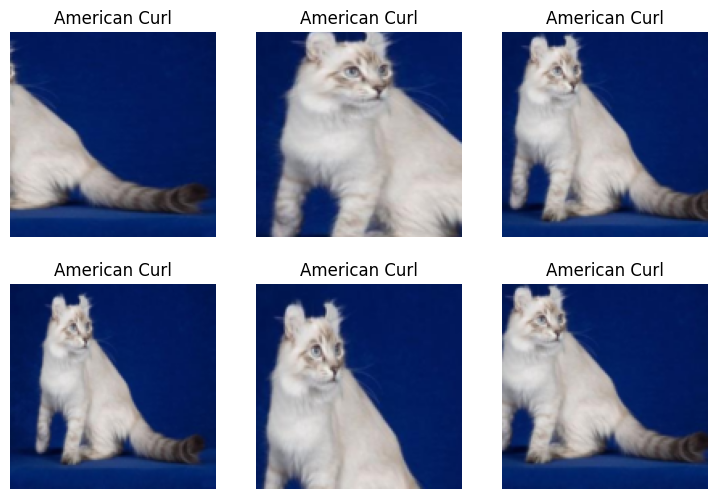

In [56]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128, min_scale=0.3)
)

dls = cats.dataloaders(path, bs=128)
dls.train.show_batch(max_n=6, nrows=2, unique=True)

In [57]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,4.447571,2.997920,0.733102,00:57


epoch,train_loss,valid_loss,error_rate,time
0,3.366763,2.625167,0.652546,01:03
1,3.013890,2.365005,0.609491,01:04
2,2.700942,2.172768,0.558565,01:03
3,2.390782,1.995036,0.520833,01:03
4,2.117199,1.861168,0.490046,01:00
5,1.907989,1.737374,0.451620,01:01
6,1.682267,1.639713,0.421528,01:02
7,1.491010,1.556523,0.399074,01:01
8,1.302698,1.477503,0.373380,01:01
9,1.175719,1.441061,0.359491,01:02


In [26]:
breed,_,probs = learn.predict(PILImage.create('examples/sphynx.jpeg'))
print(f"This is a: {breed}.")
p = dict(zip(cat_breeds, probs))
print(f"Probability it's a {breed}: {p[breed]:.4f}")

In [17]:
learn.export("model-2.pkl")

Experiment to improve prediction accuracy below.

In [19]:
# from fastai.vision.widgets import ImageClassifierCleaner
# cleaner = ImageClassifierCleaner(learn)
# cleaner

cats2 = cats.new(
    # item_tfms=RandomResizedCrop(224, min_scale=0.5),
    item_tfms=RandomResizedCrop(128, min_scale=0.3),
    # batch_tfms=[*aug_transforms(mult=2)]
    batch_tfms=[*aug_transforms(xtra_tfms=None)])

)

dls2 = cats2.dataloaders(path)
dls.train.show_batch(max_n=6, nrows=2, unique=True)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [28]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()
interp.plot_top_losses(20, nrows=10)